In [ ]:
!pip install SpeechRecognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 34.4 MB/s eta 0:00:00


In [ ]:
!pip install gTTS

In [ ]:
# import the necessary packages
import sys
import numpy as np
import argparse
import time
import cv2
import os
import speech_recognition as sr
from gtts import gTTS

In [ ]:
!wget https://github.com/AlexeyAB/darknet/raw/master/data/coco.names -O /content/coco.names

--2024-03-27 09:16:35--  https://github.com/AlexeyAB/darknet/raw/master/data/coco.names
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AlexeyAB/darknet/master/data/coco.names [following]
--2024-03-27 09:16:35--  https://raw.githubusercontent.com/AlexeyAB/darknet/master/data/coco.names
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 625 [text/plain]
Saving to: ‘/content/coco.names’

/content/coco.names 100%[===================>]     625  --.-KB/s    in 0s      

2024-03-27 09:16:35 (27.4 MB/s) - ‘/content/coco.names’ saved [625/625]



In [ ]:
#construct the argument parse and parse the arguments

import argparse

ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", required=False, default="/content/image.jpg", help="path to input image")
ap.add_argument("-y", "--yolo", required=False, default="/content/", help="base path to YOLO directory")
ap.add_argument("-c", "--confidence", type=float, default=0.5, help="minimum probability to filter weak detections")
ap.add_argument("-t", "--threshold", type=float, default=0.3, help="threshold when applying non-maxima suppression")
args = vars(ap.parse_args([]))  # Note the empty list passed to parse_args



In [ ]:
# load COCO class labels to YOLO model
labelsPath = os.path.sep.join([args["yolo"], "coco.names"])
LABELS = open(labelsPath).read().strip().split("\n")

In [ ]:
#initialize a list of colors to represent each possible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),dtype="uint8")

In [ ]:
!wget https://pjreddie.com/media/files/yolov3.weights -O /content/yolov3.weights

--2024-03-27 09:17:25--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘/content/yolov3.weights’

/content/yolov3.wei 100%[===================>] 236.52M  40.9MB/s    in 6.2s    

2024-03-27 09:18:00 (37.9 MB/s) - ‘/content/yolov3.weights’ saved [248007048/248007048]



In [ ]:
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg -O yolov3.cfg


--2024-03-27 09:18:17--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0s      

2024-03-27 09:18:17 (78.7 MB/s) - ‘yolov3.cfg’ saved [8342/8342]



In [ ]:
# derive the paths to the YOLO weights and model configuration
weightsPath = os.path.sep.join([args["yolo"], "yolov3.weights"])
configPath = os.path.sep.join([args["yolo"], "yolov3.cfg"])

In [ ]:
# load YOLO object detector trained on COCO dataset (80 classes)
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)


[INFO] loading YOLO from disk...


In [ ]:
import os

print(os.path.exists(args["image"]))  # This should print True if the file exists


True


In [ ]:
# load input image and grab the spatial dimensions
image = cv2.imread(args["image"])
if image is None:
    print(f"Failed to load image at {args['image']}. Please check the path.")
else:
    (H, W) = image.shape[:2]
    print("Image loaded successfully.")


Image loaded successfully.


In [ ]:
# Determine only the output layer names that we need from YOLO
ln = net.getLayerNames()
out_layer_indices = net.getUnconnectedOutLayers()

# Adjust for the possibility of 'getUnconnectedOutLayers' returning a flat array or a multi-dimensional one
if len(out_layer_indices.shape) == 2:  # Multi-dimensional array, likely scenario in newer OpenCV versions
    ln = [ln[i[0] - 1] for i in out_layer_indices]
else:  # Flat array, possible in older versions or specific OpenCV builds
    ln = [ln[i - 1] for i in out_layer_indices]


In [ ]:
'''
construct a blob from the input image and then perform a forward pass of the YOLO object detector
giving us the bounding box and associated probabilities
'''
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416),swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
layerOutputs = net.forward(ln)
end = time.time()


In [ ]:
# show timing information on YOLO
print("[INFO] YOLO took {:.6f} seconds".format(end - start))


[INFO] YOLO took 3.630912 seconds


In [ ]:
# initialize lists of detected bounding boxes, confidences, and class IDs, respectively
boxes = []
confidences = []
classIDs = []
ID = 0

In [ ]:
# loop over each of the layer outputs
for output in layerOutputs:
  for detection in output:
    # extract the class IDs and confidence of the current object detection
    scores = detection[5:]
    classID = np.argmax(scores)
    confidence = scores[classID]
    # filter out weak predictions by ensuring the detected probability is greater
    # than the minimum probability
    if confidence > args["confidence"]:
      # scale the bounding box coordinates back relative to the size of the
      # image, keeping in mind that YOLO actually returns the center (x, y)
      # coordinates of the bounding box followed by the boxes width and height
      box = detection[0:4] * np.array([W, H, W, H])
      (centerX, centerY, width, height) = box.astype("int")

      # use the center (x, y) coordinate to derive the top and the left corner of
      # the bounding box
      x = int(centerX - (width / 2))
      y = int(centerY - (height / 2))
      # update our list of bounding box coordinates, confidences, and class IDs
      boxes.append([x, y, int(width), int(height)])
      confidences.append(float(confidence))
      classIDs.append(classID)


In [ ]:
# apply non-maxima suppression to suppress weak, overlapping bounding boxes
idxs = cv2.dnn.NMSBoxes(boxes, confidences, args["confidence"], args["threshold"])

In [ ]:
# Draw the bounding boxes on the image
for i in idxs.flatten():
    (x, y) = (boxes[i][0], boxes[i][1])
    (w, h) = (boxes[i][2], boxes[i][3])
    color = [int(c) for c in COLORS[classIDs[i]]]
    cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
    text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
    cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)


In [ ]:
#ensure atleast one detection exists
if len(idxs) > 0:
  list1 = []
  for i in idxs.flatten():
  # extract bounding box coordinates
    (x, y) = (boxes[i][0], boxes[i][1])
    (w, h) = (boxes[i][2], boxes[i][3])
    centerx = round((2*x + w)/2)
    centery = round((2*y + h)/2)
    if centerX <= W/3:
      W_pos = "left "
    elif centerX <= (W/3 * 2):
      W_pos = "center "
    else:
      W_pos = "right "

    if centerY <= H/3:
      H_pos = "top "
    elif centerY <= (H/3 * 2):
      H_pos = "mid "
    else:
      H_pos = "bottom "
    list1.append(H_pos + W_pos + LABELS[classIDs[i]])

description = ', '.join(list1)

In [ ]:
# convert text output into speech using the google text to speech api
myobj = gTTS(text=description, lang="en", slow=False)
myobj.save("object_detection.mp3")


In [ ]:
cv2.imwrite("output.jpg", image)

True

In [ ]:
from IPython.display import Image
Image(filename="output.jpg")


In [ ]:

from IPython.display import Audio

# Create the gTTS object
myobj = gTTS(text=description, lang="en", slow=False)

# Save the speech to a temporary file
temp_file = "/content/temp_object_detection.mp3"
myobj.save(temp_file)

# Play the audio directly in Colab
Audio(temp_file, autoplay=True)


In [ ]:
import cv2
import numpy as np
import requests  # Make sure to import requests
from gtts import gTTS
from IPython.display import Audio, Image, display
import os
def detect_and_describe(url, yolo_base_path="/content/"):
    # Import statements and initial setup...
    import numpy as np
    import cv2
    import requests
    from IPython.display import Image, display, Audio
    from gtts import gTTS

    response = requests.get(url)
    image_array = np.asarray(bytearray(response.content), dtype="uint8")
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

    if image is None:
        print("Failed to load image from URL.")
        return

    labelsPath = os.path.join(yolo_base_path, "coco.names")
    LABELS = open(labelsPath).read().strip().split("\n")
    COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")

    weightsPath = os.path.join(yolo_base_path, "yolov3.weights")
    configPath = os.path.join(yolo_base_path, "yolov3.cfg")
    net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

    (H, W) = image.shape[:2]
    ln = net.getLayerNames()
    try:
        out_layers = net.getUnconnectedOutLayers()
        if out_layers.ndim == 2 and out_layers.shape[1] == 1:  # Newer OpenCV versions
            out_layer_indices = out_layers[:, 0]
        else:
            out_layer_indices = out_layers
        ln = [ln[i - 1] for i in out_layer_indices.flatten()]
    except AttributeError:  # Fallback for older OpenCV versions
        ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    layerOutputs = net.forward(ln)

    boxes = []
    confidences = []
    classIDs = []

    for output in layerOutputs:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]
            if confidence > 0.5:
                box = detection[0:4] * np.array([W, H, W, H])
                centerX, centerY, width, height = box.astype("int")

                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))

                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.3)

    if len(idxs) > 0:
        for i in idxs.flatten():
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])

            color = [int(c) for c in COLORS[classIDs[i]]]
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
            text = "{}: {:.2f}".format(LABELS[classIDs[i]], confidences[i])
            cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Save and display the image
    output_image_path = "output.jpg"
    cv2.imwrite(output_image_path, image)
    display(Image(filename=output_image_path))

    # Optionally, generate a description and convert it to speech (omitted for brevity)
    # Generating a description
    detected_items = [LABELS[i] for i in classIDs]
    description = "Detected objects: " + ", ".join(set(detected_items))
    print(description)

    # Converting description to speech
    tts = gTTS(text=description, lang="en", slow=False)
    speech_path = "description.mp3"
    tts.save(speech_path)

    # Playing the audio in the notebook
    display(Audio(speech_path, autoplay=True))


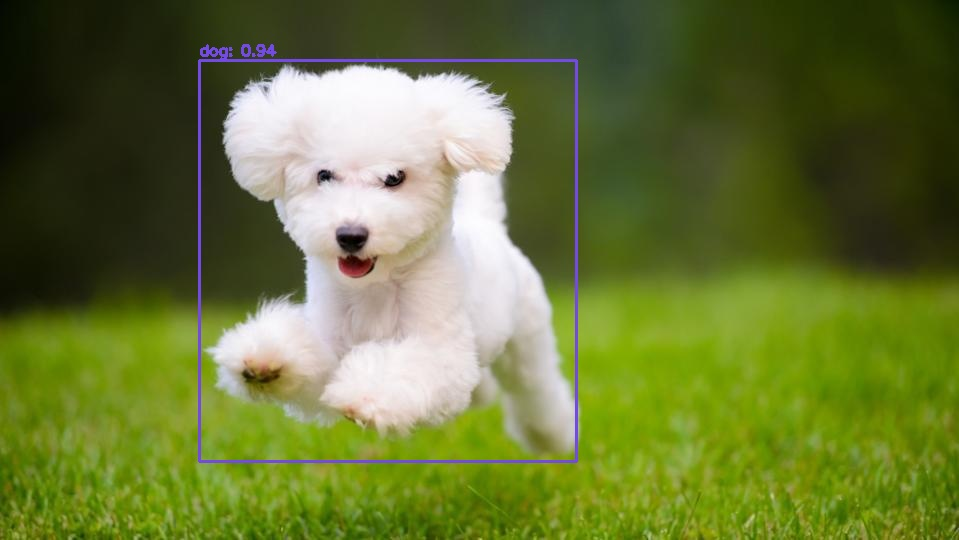

Detected objects: dog


In [ ]:
url = "https://www.forbes.com/advisor/wp-content/uploads/2023/07/top-20-small-dog-breeds.jpeg.jpg"  # Replace with your actual image URL
detect_and_describe(url)


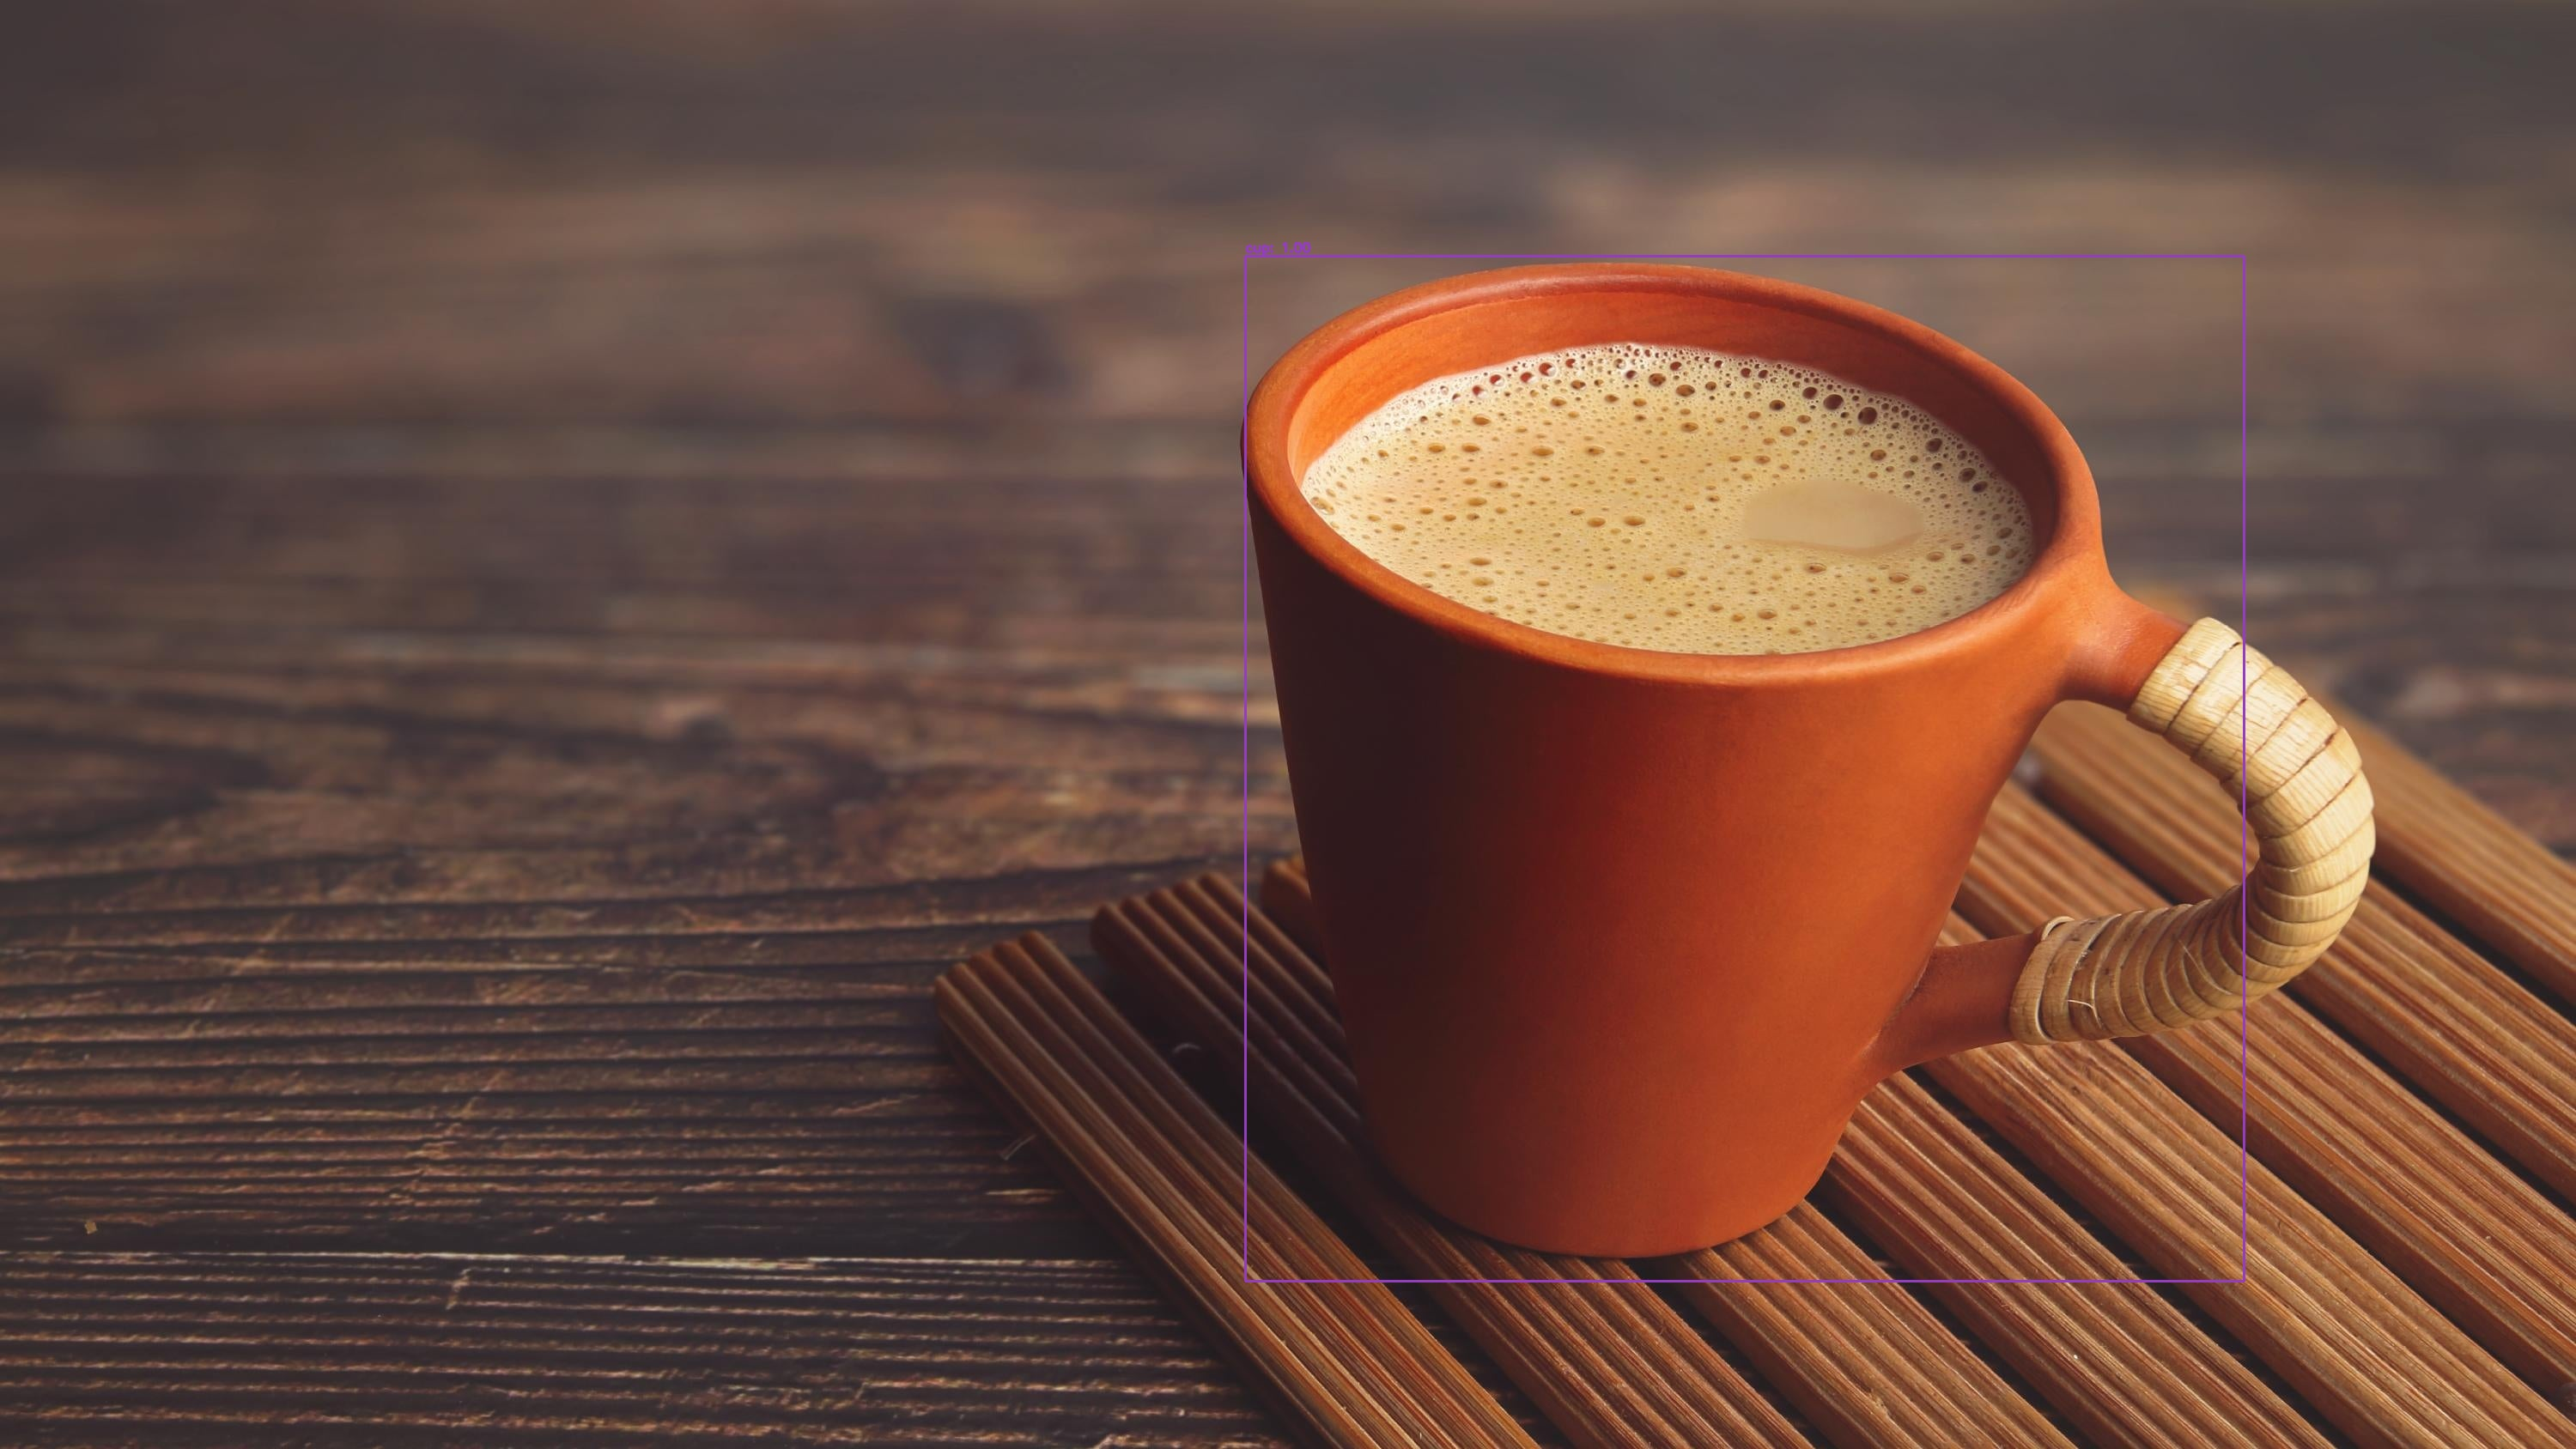

Detected objects: cup


In [ ]:
url = "https://images.expertreviews.co.uk/wp-content/uploads/2022/03/best_coffee_cup_-_lead_image.jpg"  # Replace with your actual image URL
detect_and_describe(url)
